In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ml_helpers import *

In [2]:
def awgn(signal, SNR, measured=False, return_true_snr=False):
    
    if measured:
        # Measure signal power 
        s_p = np.mean(abs(signal)**2)
    else:
        s_p = 1
    
    # Calculate noise power
    n_p = s_p/(10 **(SNR/10))
    
    # Generate complex noise
    noise = np.sqrt(n_p/2)*(np.random.randn(*signal.shape) + \
                                np.random.randn(*signal.shape)*1j)
    
    # Add signal and noise 
    signal_noisy = signal + noise 
    
    if not return_true_snr:
        return signal_noisy
    else:
        return signal_noisy, s_p/(np.mean(abs(noise)**2))
    
def pulse_shape(symbols, sps=5):
    num_weights = 251
    x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps
    sinc_weights = np.sinc(x)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    return np.convolve(padded_symbols, sinc_weights, mode='same')

In [3]:
# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

# Function to generate QPSK
def generate_qpsk(num_symbols, noise=50):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)
    
    return qpsk_symbols

# Function to generate QAM
def generate_qam(num_symbols, noise=50):
    qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                  -1-3j, -1-1j, -1+3j, -1+1j,  \
                   3-3j,  3-1j,  3+3j,  3+1j,  \
                   1-3j,  1-1j,  1+3j,  1+1j]
    ints = np.random.randint(0,16,num_symbols)
    qam_symbols = np.array([qam_scheme[i] for i in ints])
    qam_symbols = qam_symbols/np.mean(np.abs(qam_scheme))
    
    return qam_symbols

# Function to generate 4-ASK
def generate_ask4(num_symbols, noise=50):
    ask4_scheme = [3+0j, 1+0j, -1+0j, -3+0j]
    ints = np.random.randint(0,4,num_symbols)
    ask4_symbols = np.array([ask4_scheme[i] for i in ints])
    ask4_symbols = ask4_symbols/np.mean(np.abs(ask4_scheme))
    
    return ask4_symbols

# Function to generate 8-PSK
def generate_psk8(num_symbols, noise=50):
    psk8_scheme = [ 1+0j, 0.7071+0.7071j, 0+1j, -0.7071+0.7071j, \
                   -1+0j, -0.7071-0.7071j, 0-1j, 0.7071-0.7071j]
    
    ints = np.random.randint(0,8,num_symbols)
    psk8_symbols = np.array([psk8_scheme[i] for i in ints])
    psk8_symbols = psk8_symbols/np.mean(np.abs(psk8_scheme))
    
    return psk8_symbols

In [4]:
def gen_tensor_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '16-QAM'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames, sn = awgn(symbols.reshape(num_frames,-1), snr, measured=True, return_true_snr=True)

    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power

    # Split into I/Q, add extra channel to make a 4-D tensor
    return torch.FloatTensor(np.stack((frames.real, frames.imag),axis=1)), sn

In [5]:
def gen_data_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128, return_db=False):
    
    # total dataset size
    frames = torch.zeros((num_frames*len(snr_range), 2, samples_per_frame), dtype=torch.float)
    
    # snrs dataset for multitask
    snrs = torch.zeros(num_frames*len(snr_range), dtype=torch.float)
    
    for i, snr in enumerate(snr_range):
        frames[i*num_frames:(i+1)*num_frames], sn = gen_tensor_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
        if return_db:
            snrs[i*num_frames:(i+1)*num_frames] = snr
        else:
            snrs[i*num_frames:(i+1)*num_frames] = sn
    
    return frames, snrs

In [6]:
# Function returns a torch dataloader with specified batch_size and num_frames
# number of examples per snr level
def gen_loader(num_frames=32, samples_per_frame=1024, snr=[30], batch_size=32, case=1, return_db=False):
    
    if case == 1 or case == 2:
        return_db=True
    
    # Generate the individual waveforms for each modulation scheme
    bpsk_data, bpsk_snrs = gen_data_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qpsk_data, qpsk_snrs = gen_data_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    psk_data, psk_snrs = gen_data_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qam_data, qam_snrs = gen_data_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    ask_data, ask_snrs = gen_data_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    
    # Concat them into a single training data tensor
    train_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Create class labels
    bpsk_labels = torch.zeros(bpsk_data.shape[0])
    qpsk_labels = torch.ones(qpsk_data.shape[0])
    psk_labels = torch.ones(psk_data.shape[0])*2
    qam_labels = torch.ones(qam_data.shape[0])*3
    ask_labels = torch.ones(ask_data.shape[0])*4

    # Concat class labels
    # We will be using cross entropy loss, which expects a long tensor as the label hence the .long() here
    train_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels)).long()
    
    # SNR labels
    snr_labels = torch.cat((bpsk_snrs, qpsk_snrs, psk_snrs, qam_snrs, ask_snrs))
    
    if case == 0 or case == 1: 
#         snr_labels[snr_labels > 10] = 10
        train_labels_snr = snr_labels # case 0 returns linear snrs, case 1 returns dBs
    elif case == 2:
        snr_db_labels = snr_labels.numpy().astype(int)
        train_snr_range = np.arange(-15,16,2, dtype=int)
        snr_indexes = {index:value for index, value in zip(train_snr_range, np.arange(len(train_snr_range)))}
        train_labels_snr = torch.tensor(list(map(lambda label: snr_indexes[label], snr_db_labels)), dtype=int)
    
    # if gpu
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()
    train_labels_snr = train_labels_snr.cuda()
    
    # Create a Torch dataset
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels, train_labels_snr)
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
class snr_estimator(nn.Module):
    def __init__(self, num_outputs=1, relu_output=True):
        super(snr_estimator, self).__init__()
        
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        if relu_output:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(8192,512),
                                        nn.ReLU(),
                                        nn.Linear(512,64),
                                        nn.ReLU(),
                                        nn.Linear(64,num_outputs),
                                        nn.ReLU())
        else:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(8192,512),
                                        nn.ReLU(),
                                        nn.Linear(512,64),
                                        nn.ReLU(),
                                        nn.Linear(64,num_outputs))
        
    def forward(self, x):
        
        x = self.convolutions(x)
        
        x = torch.flatten(x,1)
        
        x = self.noise_estimator(x).squeeze()
        
        return x

In [8]:
def train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=5, verbose=False):
    losses, val_losses = [], []
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        
        for x,y,z in train_loader:
            optimizer.zero_grad()
            
            z_hat = model(x)
            
            loss = loss_fn(z_hat,z)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():
            running_val_loss = 0
            for x,y,z in val_loader:
                z_hat = model(x)
                
                val_loss = loss_fn(z_hat, z)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss/len(val_loader))
        
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        
        if verbose:
            print(f"Loss: {losses[-1]}, Val loss: {val_losses[-1]}")
            
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses

## Run all

In [9]:
train_snr = np.arange(-15,16,2)

num_frames_per_snr = 128
num_epochs = 30
lr = 0.0005
num_models = 3

In [33]:
train_loader = gen_loader(num_frames=num_frames_per_snr, snr=train_snr, batch_size=32, case=0)
val_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32, case=0)

loss_fn = nn.MSELoss()

models = []
for i in range(num_models):
    torch.manual_seed(i)
    
    model = snr_estimator()
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

    model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)
    
    model_config = {"weights": model.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses}
    
    models.append(model_config)
torch.save(models, f'models/snr_estimation/case_0.pt')

val_losses[-1] = 103.52779266834258, best_loss = inf, model saved at 0
val_losses[-1] = 103.5277925491333, best_loss = 103.52779266834258, model saved at 1
val_losses[-1] = 103.52779186964035, best_loss = 103.5277925491333, model saved at 2
val_losses[-1] = 29.52066659927368, best_loss = 103.52779186964035, model saved at 5
val_losses[-1] = 0.9904225847683847, best_loss = 29.52066659927368, model saved at 6
val_losses[-1] = 0.614539594296366, best_loss = 0.9904225847683847, model saved at 7
val_losses[-1] = 0.5906304309144617, best_loss = 0.614539594296366, model saved at 8
val_losses[-1] = 0.5385577840730548, best_loss = 0.5906304309144617, model saved at 10
val_losses[-1] = 0.5155684925615788, best_loss = 0.5385577840730548, model saved at 14
val_losses[-1] = 0.43402472385205326, best_loss = 0.5155684925615788, model saved at 17
val_losses[-1] = 0.3394782436080277, best_loss = 0.43402472385205326, model saved at 20
val_losses[-1] = 0.312822564644739, best_loss = 0.3394782436080277, m

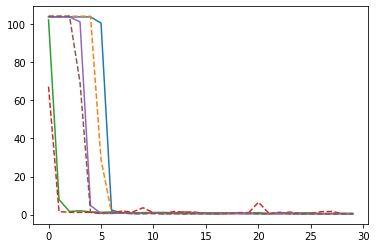

In [11]:
for config in torch.load('models/snr_estimation/case_0.pt'):
    plt.plot(config['losses'])
    plt.plot(config['val_losses'], '--')
# plt.ylim([0,5])

In [12]:
train_loader = gen_loader(num_frames=num_frames_per_snr, snr=train_snr, batch_size=32, case=1)
val_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32, case=1)

loss_fn = nn.MSELoss()

models = []
for i in range(num_models):
    torch.manual_seed(i)
    
    model = snr_estimator(relu_output=False)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

    model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)
    
    model_config = {"weights": model.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses}
    
    models.append(model_config)
torch.save(models, f'models/snr_estimation/case_1.pt')

val_losses[-1] = 2.6331297621130942, best_loss = inf, model saved at 0
val_losses[-1] = 0.6645488636568189, best_loss = 2.6331297621130942, model saved at 2
val_losses[-1] = 0.6510490417480469, best_loss = 0.6645488636568189, model saved at 13
val_losses[-1] = 2.0505890786647796, best_loss = inf, model saved at 0
val_losses[-1] = 0.7671098314225674, best_loss = 2.0505890786647796, model saved at 1
val_losses[-1] = 0.6952544212341308, best_loss = 0.7671098314225674, model saved at 2
val_losses[-1] = 0.6885837210342288, best_loss = 0.6952544212341308, model saved at 4
val_losses[-1] = 0.682902367785573, best_loss = 0.6885837210342288, model saved at 10
val_losses[-1] = 2.26912716627121, best_loss = inf, model saved at 0
val_losses[-1] = 1.282563914731145, best_loss = 2.26912716627121, model saved at 1
val_losses[-1] = 0.7821094915270805, best_loss = 1.282563914731145, model saved at 2
val_losses[-1] = 0.7076818980276585, best_loss = 0.7821094915270805, model saved at 3
val_losses[-1] = 0

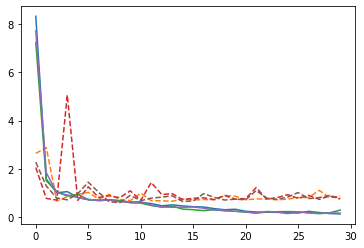

In [13]:
for config in torch.load('models/snr_estimation/case_1.pt'):
    plt.plot(config['losses'])
    plt.plot(config['val_losses'], '--')

In [14]:
train_loader = gen_loader(num_frames=num_frames_per_snr, snr=train_snr, batch_size=32, case=2)
val_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32, case=2)

loss_fn = nn.CrossEntropyLoss()

models = []
for i in range(num_models):
    torch.manual_seed(i)
    
    model = snr_estimator(num_outputs=16, relu_output=False)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

    model, losses, val_losses = train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs)
    
    model_config = {"weights": model.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses}
    
    models.append(model_config)
torch.save(models, f'models/snr_estimation/case_2.pt')

val_losses[-1] = 0.71437300555408, best_loss = inf, model saved at 0
val_losses[-1] = 0.6175178922712803, best_loss = 0.71437300555408, model saved at 1
val_losses[-1] = 0.49582773000001906, best_loss = 0.6175178922712803, model saved at 2
val_losses[-1] = 0.4196843974292278, best_loss = 0.49582773000001906, model saved at 3
val_losses[-1] = 0.40680862329900264, best_loss = 0.4196843974292278, model saved at 4
val_losses[-1] = 0.3418572017922997, best_loss = 0.40680862329900264, model saved at 10
val_losses[-1] = 0.328758480399847, best_loss = 0.3418572017922997, model saved at 13
val_losses[-1] = 0.3097533345222473, best_loss = 0.328758480399847, model saved at 19
val_losses[-1] = 0.2884976237080991, best_loss = 0.3097533345222473, model saved at 23
val_losses[-1] = 1.0132348969578744, best_loss = inf, model saved at 0
val_losses[-1] = 0.6629845511168242, best_loss = 1.0132348969578744, model saved at 1
val_losses[-1] = 0.4393538486212492, best_loss = 0.6629845511168242, model saved a

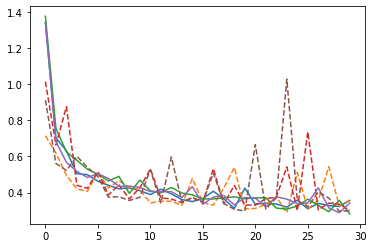

In [15]:
for config in torch.load('models/snr_estimation/case_2.pt'):
    plt.plot(config['losses'])
    plt.plot(config['val_losses'], '--')

## Run tests

In [41]:
snr_range = np.arange(-15,16)
num_frames = 128


In [42]:

results = []
for config in torch.load('models/snr_estimation/case_0.pt'):
    model = snr_estimator()
    model.cuda()
    model.load_state_dict(config['weights'])
    
    z_hats = np.zeros(len(snr_range),)
    for i, snr in enumerate(snr_range):
        z_hat = 0
        test_loader = gen_loader(num_frames=num_frames, snr=[snr], batch_size=32, case=0)
        for x,y,z in test_loader:
            z_hat += model(x)
#             z_hat_db += 10*torch.log10(z_hat)
        z_hats[i] = torch.sum(z_hat)/len(test_loader)/32
    z_hats_db = 10*np.log10(z_hats)
    
    mse = (10**(snr_range/10) - z_hats)**2
    mse_db = (snr_range-z_hats_db)**2
    
    result = {'snr_range': snr_range,
              'z_hats': z_hats,
              'z_hats_db': z_hats_db,
              'mse': mse,
              'mse_db': mse_db}

    results.append(result)
        
#     plt.plot(snr_range, z_hats_db)
# plt.plot(snr_range, snr_range, '--')

torch.save(results, 'results/snr_estimation/case_0.pt')

In [43]:
results = []
for config in torch.load('models/snr_estimation/case_1.pt'):
    model = snr_estimator(relu_output=False)
    model.cuda()
    model.load_state_dict(config['weights'])

    z_hats_db = np.zeros(len(snr_range),)
    for i, snr in enumerate(snr_range):
        z_hat_db = 0
        test_loader = gen_loader(num_frames=num_frames, snr=[snr], batch_size=32, case=1)
        for x,y,z in test_loader:
            z_hat_db += model(x)
        z_hats_db[i] = torch.sum(z_hat_db)/len(test_loader)/32
        z_hats = 10**(z_hats_db/10)
    
    mse = (10**(snr_range/10) - z_hats)**2
    mse_db = (snr_range-z_hats_db)**2
    
    result = {'snr_range': snr_range,
              'z_hats': z_hats,
              'z_hats_db': z_hats_db,
              'mse': mse,
              'mse_db': mse_db}

    results.append(result)
    
#     plt.plot(snr_range, z_hats_db)
# plt.plot(snr_range, snr_range, '--')

torch.save(results, 'results/snr_estimation/case_1.pt')

In [44]:
train_snr_range = np.arange(-15,16,2)

results = []
for config in torch.load('models/snr_estimation/case_2.pt'):
    model = snr_estimator(num_outputs=16, relu_output=False)
    model.cuda()
    model.load_state_dict(config['weights'])

    z_hats_db, z_hats = np.zeros(len(snr_range),), np.zeros(len(snr_range),)
    for i, snr in enumerate(snr_range):
        z_hat_db = 0
        test_loader = gen_loader(num_frames=num_frames, snr=[snr], batch_size=32, case=1)
        for x,y,z in test_loader:
            z_hat = model(x).argmax(axis=1)
            z_hat_db += torch.tensor(train_snr_range[z_hat.cpu().detach()])#10*torch.log10(z_hat)
        z_hats_db[i] = torch.sum(z_hat_db)/len(test_loader)/32
    z_hats = 10**(z_hats_db/10)
    
    mse = (10**(snr_range/10) - z_hats)**2
    mse_db = (snr_range-z_hats_db)**2
    
    result = {'snr_range': snr_range,
              'z_hats': z_hats,
              'z_hats_db': z_hats_db,
              'mse': mse,
              'mse_db': mse_db}

    results.append(result)
#     plt.plot(train_snr_range, z_hats_db)
    
# plt.plot(train_snr_range, train_snr_range, '--')

torch.save(results, 'results/snr_estimation/case_2.pt')

In [19]:
cases = [0, 1, 2]

case 0: 2.4428826412041142
case 1: 0.17534382383707817
case 2: 0.16192877023454175


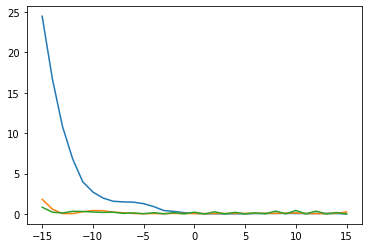

In [35]:
for case in cases:
#     for result in torch.load(f'results/snr_estimation/case_{case}.pt'):
#         plt.plot(result['snr_range'], result['mse_db'], color=f'C{case}')
    mse = [result['mse_db'] for result in torch.load(f'results/snr_estimation/case_{case}.pt')]
    print(f'case {case}: {np.mean(mse)}')
    plt.plot(result['snr_range'], np.mean(mse,axis=0))
#     plt.ylim([0,10])

case 0: 0.14175145307753204
case 1: 0.525036671014682
case 2: 0.5035362639660911


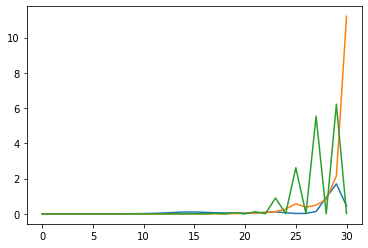

In [21]:
for case in cases:
    mse = [result['mse'] for result in torch.load(f'results/snr_estimation/case_{case}.pt')]
    print(f'case {case}: {np.mean(mse)}')
    plt.plot(np.mean(mse,axis=0))

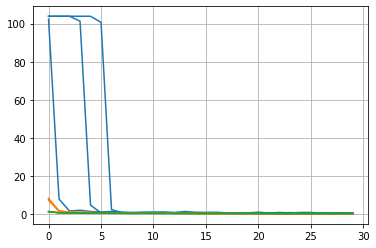

In [23]:
for case in cases:
    for config in torch.load(f'models/snr_estimation/case_{case}.pt'):
        plt.plot(config['losses'], f'C{case}')
#         plt.plot(config['val_losses'], f'C{case}--')
# plt.ylim([0,2.5])
plt.grid()

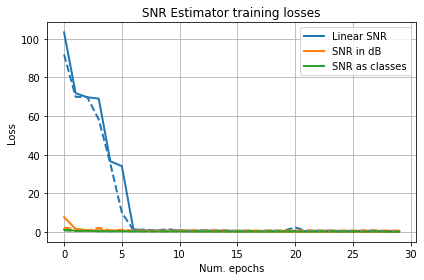

In [24]:
for case in cases:
    plt.plot(np.mean([config['losses'] for config 
                      in torch.load(f'models/snr_estimation/case_{case}.pt')],axis=0), f'C{case}', linewidth=2)
for case in cases:
    plt.plot(np.mean([config['val_losses'] for config 
                      in torch.load(f'models/snr_estimation/case_{case}.pt')],axis=0), f'C{case}--', linewidth=2)
#         plt.plot(config['val_losses'], f'C{case}--')
# plt.ylim([0,2.5])
plt.xlabel('Num. epochs'); plt.ylabel('Loss')
plt.title('SNR Estimator training losses')
plt.legend(['Linear SNR',
            'SNR in dB',
            'SNR as classes'])
plt.grid()
plt.tight_layout()
# plt.savefig('figures/snr_estimator_losses.svg', dpi=300)

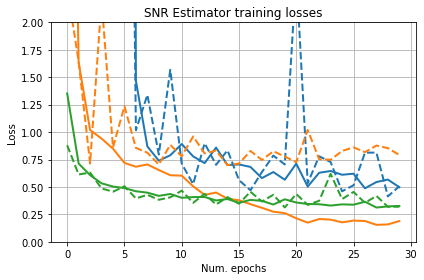

In [25]:
for case in cases:
    plt.plot(np.mean([config['losses'] for config 
                      in torch.load(f'models/snr_estimation/case_{case}.pt')],axis=0), f'C{case}', linewidth=2)
for case in cases:
    plt.plot(np.mean([config['val_losses'] for config 
                      in torch.load(f'models/snr_estimation/case_{case}.pt')],axis=0), f'C{case}--', linewidth=2)
#         plt.plot(config['val_losses'], f'C{case}--')
plt.ylim([0,2])
plt.xlabel('Num. epochs'); plt.ylabel('Loss')
plt.title('SNR Estimator training losses')
# plt.legend(['Linear SNR',
#             'SNR in dB',
#             'SNR as classes'])
plt.grid()
plt.tight_layout()
plt.savefig('figures/snr_estimator_losses_zoom.png', dpi=300)

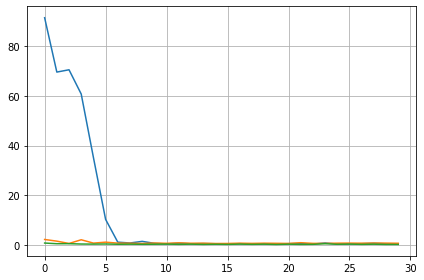

In [36]:
for case in cases:
    plt.plot(np.mean([config['val_losses'] for config 
                      in torch.load(f'models/snr_estimation/case_{case}.pt')],axis=0), f'C{case}')
# plt.ylim([0,2.5])
plt.grid()
plt.tight_layout()

In [27]:
torch.load(f'results/snr_estimation/case_{case}.pt')[0].keys()

dict_keys(['snr_range', 'z_hats', 'z_hats_db', 'mse', 'mse_db'])

In [28]:
markers = ['s', 'x', '>']

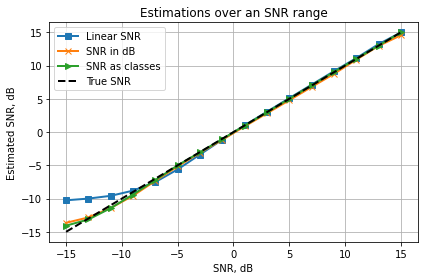

In [47]:
for case in cases:
    plt.plot(snr_range[np.arange(0,31,2)], np.mean([config['z_hats_db'][np.arange(0,31,2)] for config 
                      in torch.load(f'results/snr_estimation/case_{case}.pt')],axis=0), f'C{case}-{markers[case]}', linewidth=2)
plt.plot(snr_range, snr_range, '--k', linewidth=2)
# plt.ylim([0,2.5])
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Estimated SNR, dB')
plt.title('Estimations over an SNR range')
plt.legend(['Linear SNR',
            'SNR in dB',
            'SNR as classes',
            'True SNR'])
plt.tight_layout()
# plt.savefig('figures/snr_estimator_results_db.png', dpi=300)

In [30]:
print(np.mean([config['mse_db'][np.arange(0,31,2)] for config 
                  in torch.load(f'results/snr_estimation/case_{case}.pt')], axis=0))

[8.26302147e-01 1.08385471e-01 3.00572716e-01 1.82343923e-01
 6.75520603e-02 1.19791865e-02 3.38542064e-03 1.82291716e-03
 8.85416965e-04 1.14583015e-03 0.00000000e+00 7.55209128e-03
 4.21876431e-03 2.55206108e-03 1.04163488e-04 5.20841281e-04]


In [31]:
snr_range[np.arange(0,31,2)]

array([-15, -13, -11,  -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,
        11,  13,  15])

2.780705502201341
0.20762758983777516
0.1053182092262801


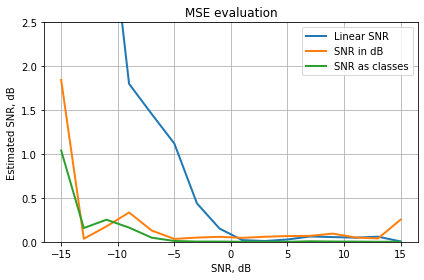

In [46]:
for case in cases:
#     plt.plot(snr_range[np.arange(0,31,2)], np.mean([config['mse_db'][np.arange(0,31,2)] for config 
#                       in torch.load(f'results/snr_estimation/case_{case}.pt')],axis=0), f'C{case}', linewidth=2)
    plt.plot(snr_range[np.arange(0,31,2)], np.mean([config['mse_db'][np.arange(0,31,2)] for config 
                  in torch.load(f'results/snr_estimation/case_{case}.pt')],axis=0), f'C{case}', linewidth=2)
    print(np.mean([config['mse_db'][np.arange(0,31,2)] for config 
                  in torch.load(f'results/snr_estimation/case_{case}.pt')]))
    
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Estimated SNR, dB')
plt.title('MSE evaluation')
plt.legend(['Linear SNR',
            'SNR in dB',
            'SNR as classes',
            'True SNR'])
plt.ylim([0,2.5])
plt.tight_layout()
# plt.savefig('figures/snr_estimator_results_mse.png', dpi=300)